# MlLibを使ってみた

以下のQiitaの記事のコピペ
http://qiita.com/tkazusa/items/2c1d41ace16a3e2d2c6a

In [1]:
# おまじない
import sys, os
spark_home = '/usr/local/lib/spark2.0.1'
os.environ["SPARK_HOME"] = spark_home
os.environ["PYSPARK_PYTHON"] = '/usr/local/bin/python3'
sys.path.insert(0, '{}/python/'.format(spark_home))
sys.path.insert(0, '{}/python/lib/py4j-0.10.3-src.zip'.format(spark_home))
import pyspark
conf = pyspark.SparkConf().setMaster("local[8]")
sc = pyspark.SparkContext(conf=conf)

In [2]:
import numpy as np
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint

# rawTrainData = sc.textFile("data/train.txt").map(lambda x: x.replace('\t', ',')).cache()
# rawTestData = sc.textFile("data/test.txt").map(lambda x: x.replace('\t', ',')).cache()

raw_data = sc.textFile("data/train_tiny.txt").map(lambda x: x.replace('\t', ','))
rawTrainData, rawTestData = raw_data.randomSplit([.9, .1], seed = 42)

OneSample = rawTrainData.take(1)
print(OneSample)

print("")
print("Number of data")
print("Train:\t{}".format(rawTrainData.count()))
print("Test:\t{}".format(rawTestData.count()))

['0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']

Number of data
Train:	450090
Test:	49910


In [3]:
def createOneHotDict(inputData):
    OHEDict = (inputData
               .flatMap(lambda x: x)
               .distinct()
               .zipWithIndex()
               .collectAsMap())
    return OHEDict


def parsePoint(point):
    items = point.split(',')
    return [(i, item) for i, item in enumerate(items[1:])]

def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    sizeList = [OHEDict[f] for f in rawFeats if f in OHEDict]
    sortedSizeList = sorted(sizeList)
    valueList = [1 for f in rawFeats if f in OHEDict ]
    return SparseVector(numOHEFeats, sortedSizeList, valueList)


def parseOHEPoint(point, OHEDict, numOHEFeats):
    parsedPoints = parsePoint(point)
    items = point.split(',')
    label = items[0]
    features = oneHotEncoding(parsedPoints, OHEDict, numOHEFeats)
    return LabeledPoint(label, features)

parsedFeat = rawTrainData.map(parsePoint)
ctrOHEDict = createOneHotDict(parsedFeat)
numCtrOHEFeats = len(ctrOHEDict.keys())


OHETrainData = rawTrainData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats)).cache()
OHETestData = rawTestData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats)).cache()

print('Feature size after OHE:\t{0}'.format(numCtrOHEFeats))

print(OHETrainData.take(1))

Feature size after OHE:	786056
[LabeledPoint(0.0, (786056,[566,39604,41923,58676,69781,90928,112857,131445,195282,220601,252193,322478,334026,334516,337592,345770,356285,375026,407268,409659,422609,434255,442902,489382,504248,533543,560252,601474,620206,686699,700280,700396,707174,734306,735807,742414,746222,763609,765494],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [4]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

numIters = 100
regParam = 0.01
regType = 'l2'
includeIntercept = True

model0 = LogisticRegressionWithLBFGS.train(data = OHETrainData, 
                                         iterations = numIters,
                                         regParam = regParam,
                                         regType = regType,
                                         intercept = includeIntercept)

#Compute loglos
from math import log, exp 

def computeLogLoss(p, y):
    epsilon = 10e-12
    if y == 1:
        return -log(epsilon + p) if p == 0 else -log(p)
    elif y == 0:
        return -log(1 - p + epsilon) if p == 1 else -log(1 - p)

def getP(x, w, intercept):
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1.0 / (1.0 + exp(-rawPrediction))

def evaluateResults(model, data):
    return data.map(lambda x: computeLogLoss(getP(x.features, model.weights, model.intercept), x.label)).sum() / data.count()

print ('Test Logloss for model1:\n\t = {0}'
       .format(evaluateResults(model0, OHETestData)))

Test Logloss for model1:
	 = 0.6602566549429516


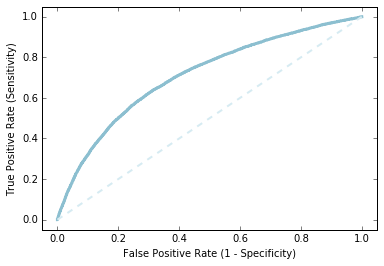

In [5]:
labelsAndScores = OHETestData.map(lambda lp: (lp.label, getP(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda t: t[1], reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = plt.subplot(111)

ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)